# Chapter 5. Support Vector Machines

支持向量机（SVM）是一种功能强大且多功能的机器学习模型，能够执行线性或非线性分类、回归甚至异常值检测。它是机器学习中最受欢迎的模型之一，任何对机器学习感兴趣的人都应该把它放在工具箱里。支持向量机特别适合对复杂的中小型数据集进行分类。

本章将解释支持向量机的核心概念，如何使用它们，以及它们是如何工作的。

## Linear SVM Classification

支持向量机背后的基本想法最好用一些图片来解释。图5-1显示了第4章末尾引入的部分 iris 数据集。这两个类可以很容易地用直线分开（它们是线性可分的）。左图显示了三个可能的线性分类器的决策边界。决策边界由虚线表示的模型非常糟糕，甚至没有正确地分离类。其他两个模型在这个训练集上工作得很好，但他们的决策边界非常接近实例，以至于这些模型在新实例上的表现可能不太好。相比之下，右侧绘图中的实线表示支持向量机分类器的决策边界；该线不仅将两个类分开，而且尽可能远离最近的训练实例。您可以将支持向量机分类器视为适合类之间尽可能宽的 street（以平行虚线表示）。这被称为 `large margin classification.`。

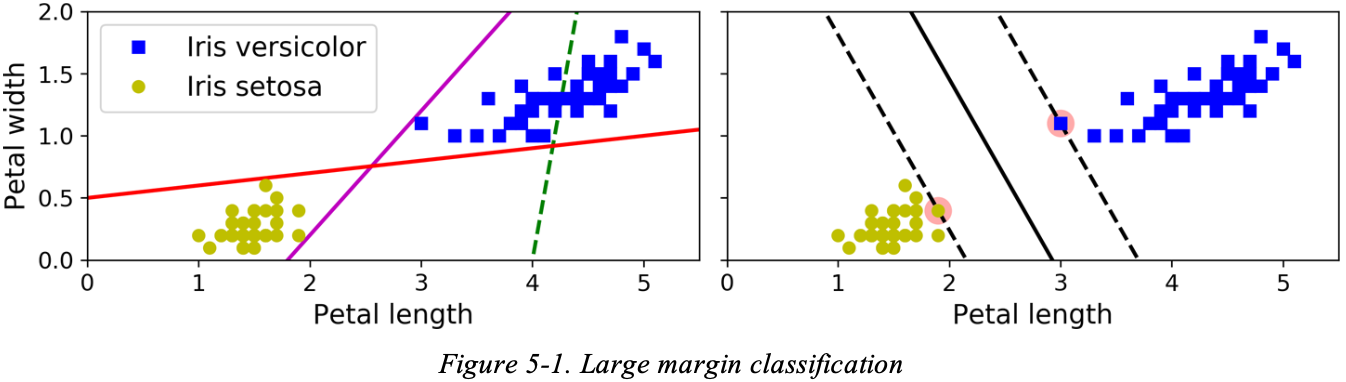

请注意，添加更多 “off the street” 训练实例根本不会影响决策边界：它完全由位于  edge of the street 的实例确定（或“supported”）。 这些实例被叫做 `support vectors` （在图 5-1 中被圈出）。

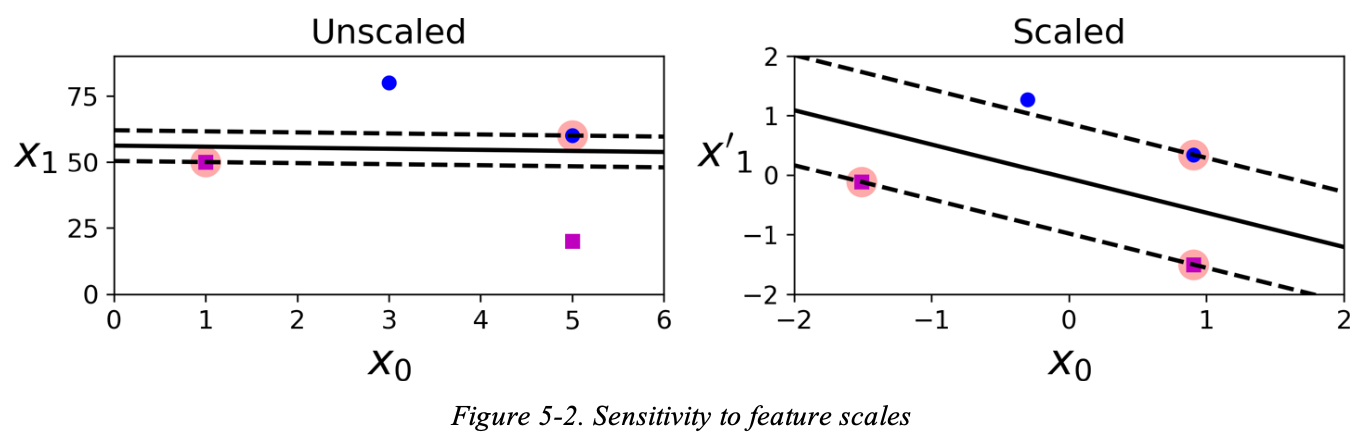

> WARNING: 支持向量机对特征尺度很敏感，如图5-2所示：在左侧 plot 中，vertical scale 比 horizontal scale 大得多，因此尽可能宽的 street 接近 horizontal。 在特征缩放（例如，使用Scikit-Learn `StandardScaler`）后，正确 plot 中的决策边界看起来要好得多。

### Soft Margin Classification

如果我们严格规定所有实例都必须在 street 外和右侧，这被称为 `hard margin classification`。`hard margin classification` 有两个主要问题。首先，只有当数据线性可分时，它才会起作用。其次，它对异常值很敏感。图5-3显示了只有一个额外异常值的 iris 数据集：在左侧，不可能找到 hard margin；在右侧，决策边界最终与我们在图5-1中看到的没有异常值的边界非常不同，它可能不会具有泛化性。

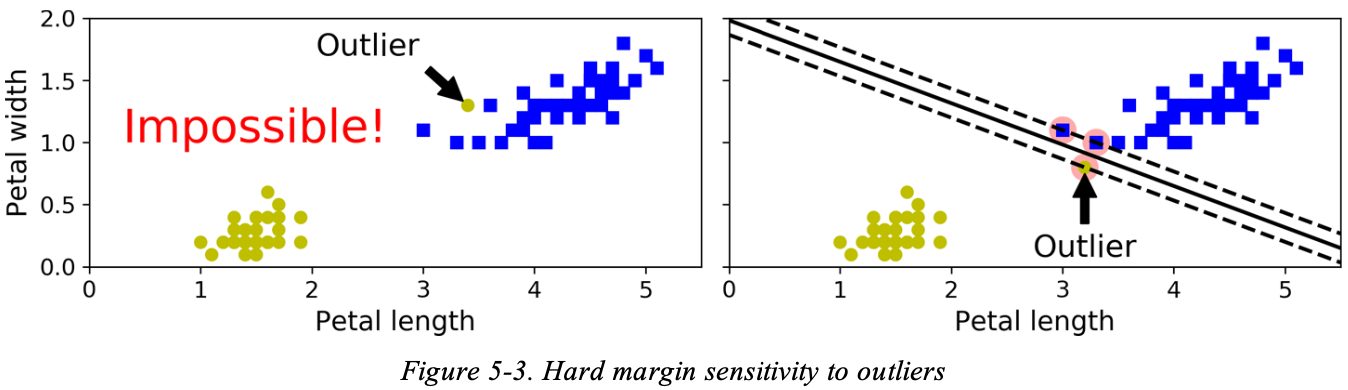

为了避免这些问题，请使用更灵活的模型。目标是在保持 street 尽可能大和限制 `margin violations`（即最终位于 street 中间甚至错误一侧的情况）之间找到良好的平衡。这叫作 `soft margin classification`。

使用 Scikit-Learn 创建 SVM 模型时，我们可以指定一些超参数。 `C` 是其中一个超参数。 如果我们将它设的很小， 我们最终得到图 5-4 左侧的模型。 如果设的很大， 我们最终得到右侧的模型。 Margin violations 不好。它们越少越好。然而，在这种情况下，左侧的模型有很多 margin violations 的行为，但可能会泛化性更好。

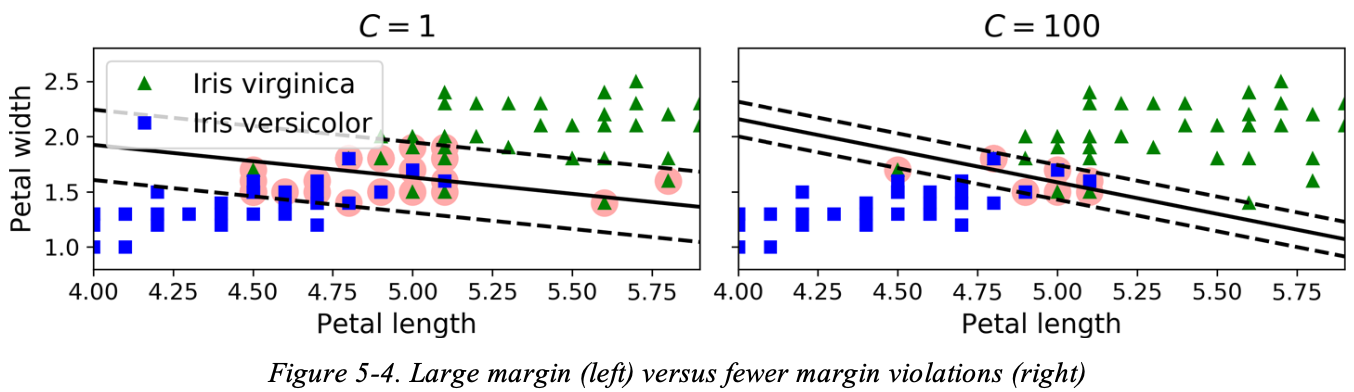

> TIP: 如果您的SVM模型过拟合，您可以尝试通过减少 `C` 来正则化

以下Scikit-Learn代码加载 iris 数据集，缩放特征，然后训练线性 SVM 模型(使用 `LinearSCV` 类和 `hinge loss` 函数) 来检测 Iris virginica 花:

In [3]:
import numpy as np
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

iris = datasets.load_iris()
X = iris["data"][:, (2, 3)] # petal length, petal width
y = (iris["target"] == 2).astype(np.float64) # Iris virginica

svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("linear_svc", LinearSVC(C=1, loss="hinge"))
])

svm_clf.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('linear_svc', LinearSVC(C=1, loss='hinge'))])

In [2]:
svm_clf.predict([[5.5, 1.7]])

array([1.])

> NOTE: 与逻辑回归分类器不同，SVM分类器不会输出每个类的概率。

与使用 `LinearSVC` 类不同， 我们可以使用带有一个 linear kernel 的 `SVC` 类。 当创建 SVC 模型时， 我们将会写 `SVC(kernel='linear', C=1)`。 或者我们可以使用 `SGDClassifier` 类， 使用 `SGDClassifier(loss="hinge", alpha=1/(m*C))` 。 这应用正则随机梯度下降（见第4章）来训练线性SVM分类器。它收敛速度不如类 `LinearSVC` 快，但它可以可用于处理在线分类任务或放不到内存的巨大数据集（out-of-core training）。

> TIP: `LinearSVC` 类对偏置项进行正则化，因此您应该通过减去其平均值来集中训练。这会自动完成如果你使用 `StandardScaler` 缩放数据。 此外，请确保将 `loss` 超参数设置为 `hinge`，因为它不是默认值。最后，为了获得更好的性能，您应该设置 `dual` 超参数，除非有比训练实例更多的特征（我们将在本章后面讨论二元性）。

## Nonlinear SVM Classification

虽然线性支持向量机分类器效率高，在许多情况下效果出人意料地好，但许多数据集无法线性分离。处理非线性数据集的一种方法是添加更多特征，例如多项式特征（如您在第4章中所做的）；在某些情况下，这可能会导致线性可分的数据集。考虑图5-5中的左图：它表示一个简单的数据集，只有一个特征，$x_1$。正如您所看到的，此数据集不线性可分。但是，如果您添加第二个特征 $x2 = (x_1)^2$，则生成的2D数据集完全线性可分。

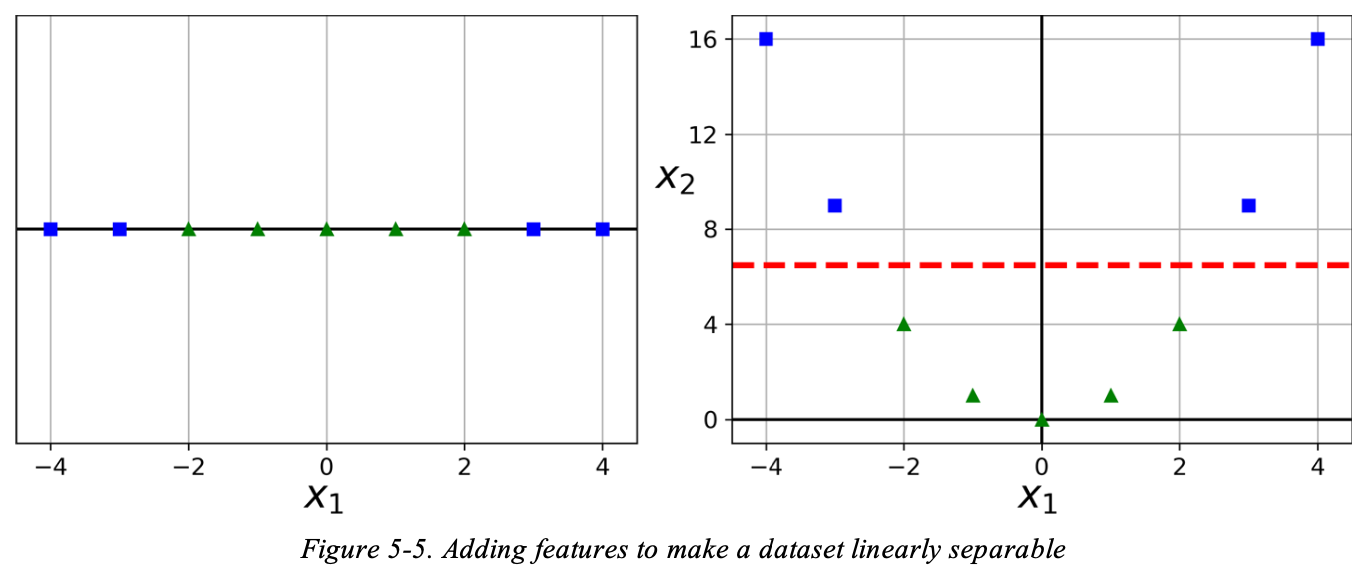

为了使用 Scikit-Learn 实现这个想法， 创建一个包含 `PolynomialFeatures` 变换的 `Pipeline`， 后面接一个 `StandardScaler` 和 一个 `LinearSVC`。 让我们在卫星数据集上测试一下：这是一个用于二分类的玩具数据集，其中数据点被塑造成两个交错的半圆(图 5-6)。 您可以使用 `make_moons()` 函数生成此数据集：

In [4]:
from sklearn.datasets import make_moons
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

X, y = make_moons(n_samples=100, noise=0.15)
polynomial_svm_clf = Pipeline([
    ("poly_features", PolynomialFeatures(degree=3)),
    ("scaler", StandardScaler()),
    ("svm_clf", LinearSVC(C=10, loss="hinge"))
])
polynomial_svm_clf.fit(X, y)

/Users/shawnd/miniforge3/envs/keras/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Pipeline(steps=[('poly_features', PolynomialFeatures(degree=3)),
                ('scaler', StandardScaler()),
                ('svm_clf', LinearSVC(C=10, loss='hinge'))])

此代码使用三度多项式内核训练SVM分类器。它在 图5-7 的左侧表示。右边是另一个使用 10th-degree polynomial kernel 的 SVM 分类器。显然， 如果你的模型过拟合， 你可能想要减少 polynomial degree.相反，如果它欠拟合，你可以尝试增大它。超参数 `coef0` 控制模型在多大程度上  high-degree polynomials 和 low-degree polynomials 的影响。

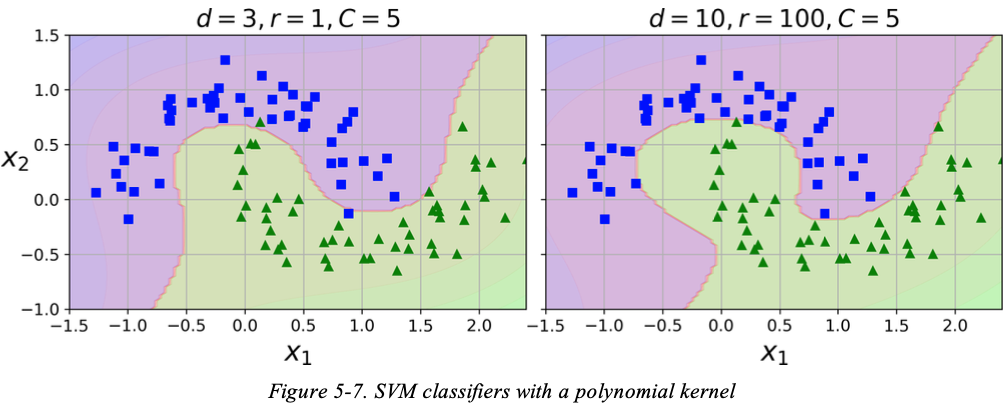

> TIP: 找到正确超参数值的常见方法是使用网格搜索(见第2章)。首先进行非常粗略的网格搜索，然后围绕找到的最佳值进行更精细的网格搜索通常更快。很好地了解每个超参数的实际功能也可以帮助您在超参数空间的正确部分进行搜索。

### Similarity Features

解决非线性问题的另一种技术是添加使用相似性函数计算的特征，该函数测量每个实例与特定 landmark 的相似程度。例如，让我们取之前讨论的 1D 数据集，并在 $x_1 = –2$ 和 $x1 = 1$ 上添加两个 landmark（见图5-8中的左图）。接下来，让我们将相似性函数定义为 $\gamma = 0.3$ 的高斯  `Radial Basis Function(RBF)`（见方程5-1）。

$$
\phi_y(x, l) = \exp(-\gamma \| x - l \|^2)
$$

这是一个钟形函数，从 0(离 landmark 很远) 到1 (在 landmark 处)。现在，我们已准备好计算新特征。例如，让我们看看实例 $x_1 = –1$：它离第一个 landmark 的距离为1，距离第二个 landmark 2。因此新特征为 $x_2 = \exp(-0.3 \times 1^2) \approx 0.74$ 和 $x_3 = \exp(-0.3 \times 2^2) \approx 0.30$。图5-8中右侧的绘图显示了转换后的数据集（删除原始特征）。如您所见，它现在线性可分。

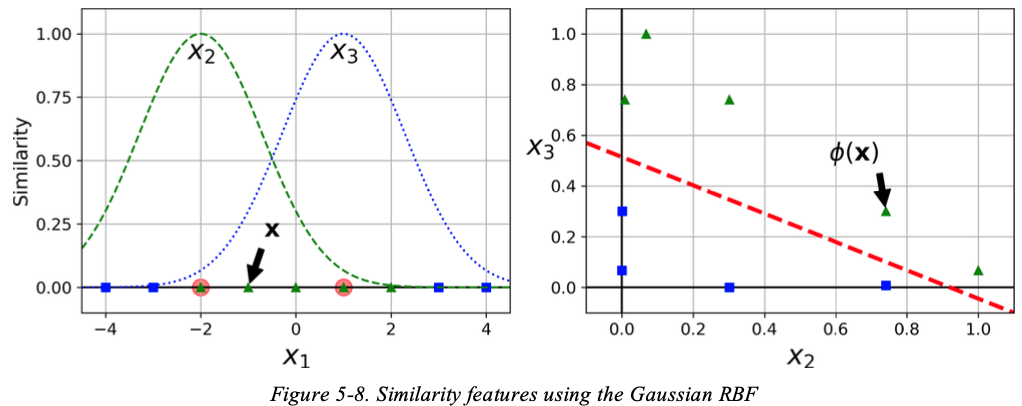

您可能想知道如何选择 landmarks。最简单的方法是在数据集中的每个实例的位置创建一个 landmarks。这样做会创建许多维度，从而增加转换后的训练集线性可分的机会。缺点是，具有 $m$ 个实例和 $n$ 个特征的训练集会转换为具有 $m$ 个实例和 $m$ 个特征的训练集（假设您放弃了原始特征）。如果您的训练集非常大，您最终会获得同样多的特征。

### Gaussian RBF Kernel

就像多项式特征方法一样，相似性特征方法对任何机器学习算法都很有用，但计算所有附加特征可能在计算上很昂贵，特别是在大型训练集上。 kernel trick 再次发挥其支持向量机的魔力，使获得类似的结果成为可能，就像您添加了许多相似性特征一样。让我们尝试使用高斯 RBF kernel 的 `SVC` 类：

In [7]:
from sklearn.svm import SVC
rbf_kernel_svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("svm_clf", SVC(kernel="rbf", gamma=5, C=0.001))
])
rbf_kernel_svm_clf.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', SVC(C=0.001, gamma=5))])

该模型在图5-9的左下角表示。其他图显示了使用不同值超参数 $gamma(\gamma)$ 和 $C$。 不断增加 `gamma` bell-shape 曲线更窄（见图5-8中的右图）。因此，每个实例的影响范围较小：决策边界最终更加不规则，在单个实例周围晃动。相反，一个小值使 bell-shape 曲线更宽：实例的影响范围更大，决策边界最终更平滑。因此，$\gamma$ 就像一个正则化超参数：如果您的模型过拟合，您应该减少它；如果它欠拟合，您应该增加它（类似于 `C` 超参数）。

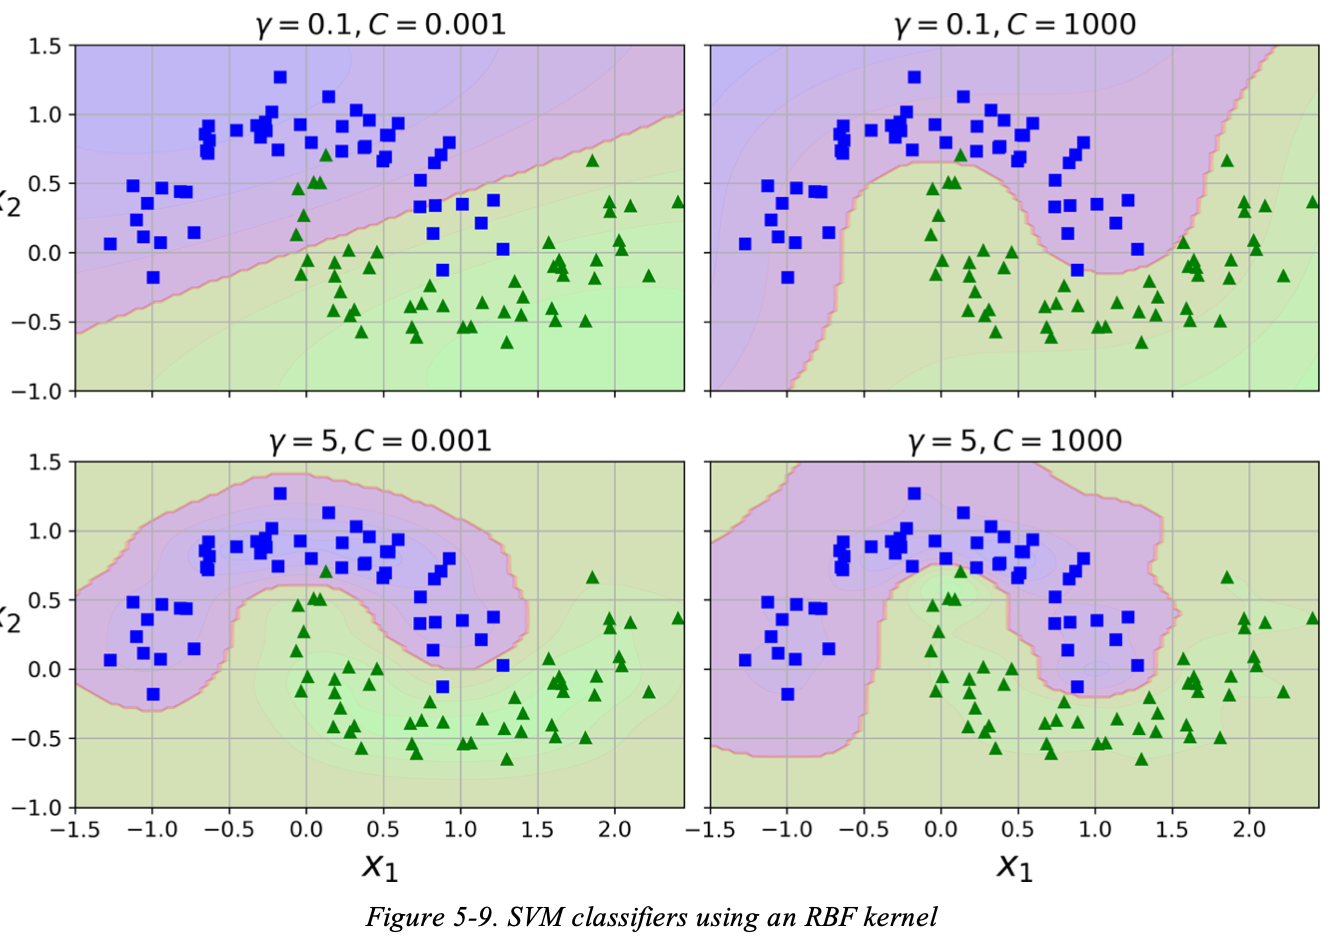

其他 kernel 存在，但 使用得更少。一些 kernel 专门用于特定的数据结构。 `String kernels` 有时用于分类文本文档和 DNA 序列(例如， 使用 `string subsequence kernel` 或基于 `Levenshtein distance` 的 kernel)。

> TIP: 有这么多 kernel 可供选择，你如何决定使用哪个 kernel？ 根据经验，您应该始终先尝试线性 kernel（记住 `LinearSVC` 比 `SVC(kernel="linear")` 快得多）， 特别是如果训练集非常大，或者它有很多特征。如果训练集不太大，您还应该尝试高斯RBF kernel；它在大多数情况下效果很好。然后，如果您有空闲时间和计算能力，您可以使用交叉验证和网格搜索来尝试其他几个kernel。您想进行这样的实验，特别是如果有专门用于训练集数据结构的kernel。 

### Computational Complexity

`LinearSVC` 类基于 `liblinear` 库， 其实现了一种为 linear SVMs 优化的算法。 它不支持 kernel trick，但它几乎随着训练实例的数量和特征数量而线性地缩放。 它的训练时间复杂度大约为 $O(m \times n)$。

如果你需要更高的准确率， 算法需要更长的时间。 这由 tolerance 超参数 $\epsilon$（在Scikit-Learn中称为 `tol`）控制。在大多数分类任务中，默认 tolerance 是可以的。

`SVC` 类基于 `libsvm` 库，库实现了支持 kernel trick 的算法。训练时间复杂度通常在 $O(m^2 \times n)$ 和 $O(m^3 \times n)$ 之间。不幸的是，这意味着当训练实例数量增加（例如数十万个实例）时，它会变得非常缓慢。该算法非常适合复杂的中小型训练集。它随着特征的数量而很好地扩展，特别是稀疏的特征（即当每个实例几乎没有非零特征时）。在这种情况下，该算法大致根据每个实例的非零特征的平均数量进行缩放。表5-1比较了 Scikit-Learn 的 SVM classification classes。

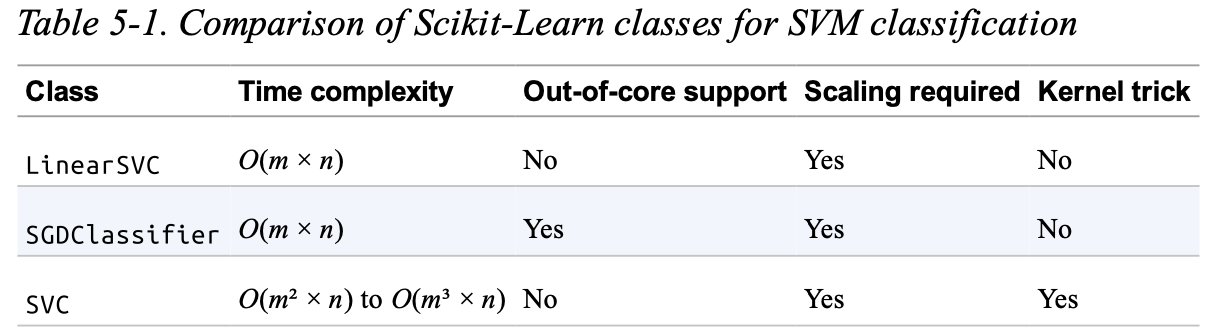

## SVM Regression

如前所述，支持向量机算法用途广泛：它不仅支持线性和非线性分类，还支持线性和非线性回归。使用支持向量机进行回归而不是分类，诀窍是 reverse the objective ：SVM回归试图在限制 margin violations 的同时在两个类别之间匹配尽可能大的 street，而是试图在 street 上尽可能多地拟合实例，同时限制 margin violations（即 street 外的实例）。 street 的宽度由超参数 $\epsilon$ 控制。图5-10显示了两个在一些随机线性数据上训练的线性支持向量机回归模型，一个 margin 大($\epsilon = 1.5$），另一个 margin 小($\epsilon = 0.5$)。

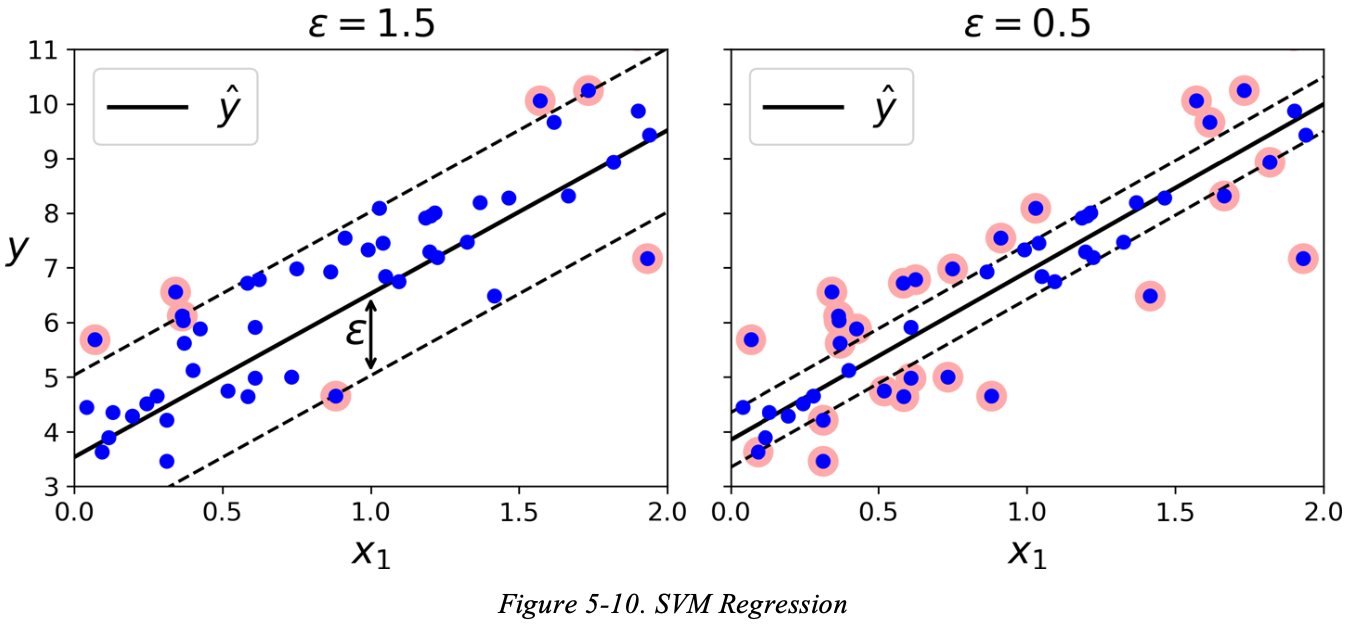

在 margin 内添加更多训练实例不会影响模型的预测；因此，该模型被称为 $\epsilon-insensitive$。您可以使用 Scikit-Learn 的 `LinearSVR` 类来执行线性SVM 回归。以下代码生成图5-10中左侧表示的模型（训练数据应首先缩放和居中）：

In [8]:
from sklearn.svm import LinearSVR

svm_reg = LinearSVR(epsilon=1.5)
svm_reg.fit(X, y)

LinearSVR(epsilon=1.5)

要解决非线性回归任务，您可以使用 kernelized 支持向量机模型。图5-11显示了使用 second-degree 多项式 kernel 的随机二次训练集上的 SVM 回归。左图中的正则化很少（即 `C` 值大），右图中的正则化要多得多（即 `C` 值小）。

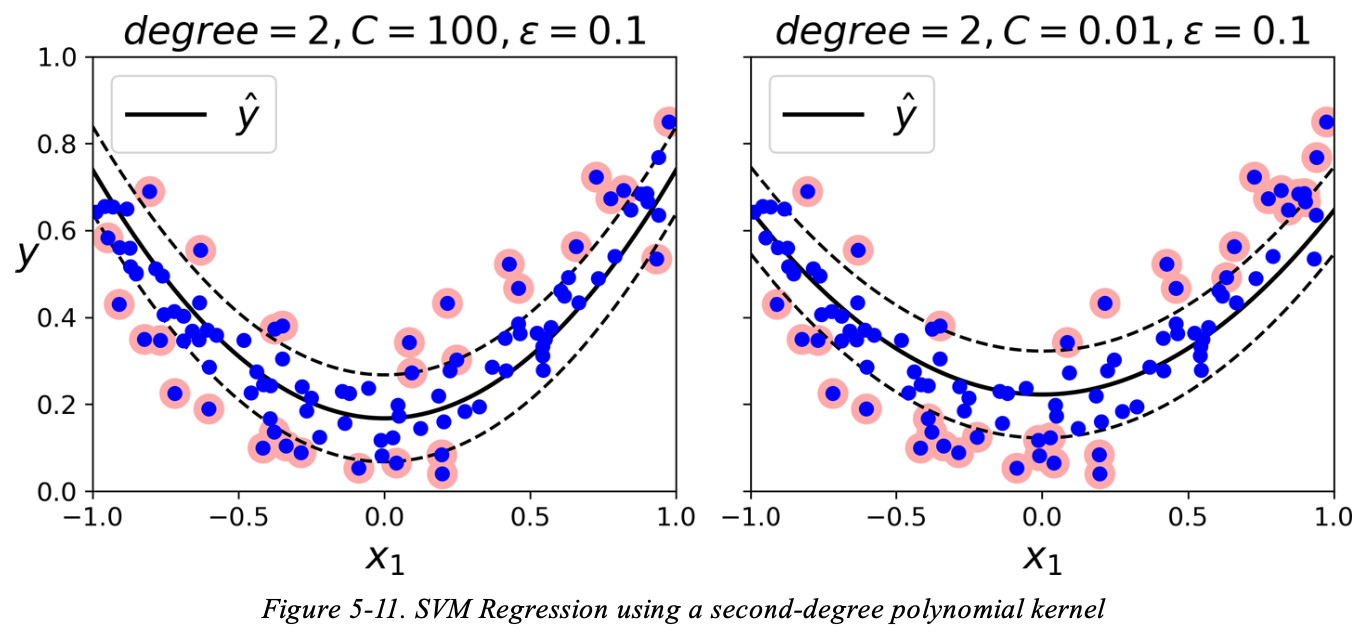

以下代码使用 Scikit-Learn 的 `SVR` 类（支持 kernel trick）生成图5-11中左侧表示的模型：

In [9]:
from sklearn.svm import SVR

svm_poly_reg = SVR(kernel = "poly", degree=2, C=100, epsilon=0.1)
svm_poly_reg.fit(X, y)

SVR(C=100, degree=2, kernel='poly')

`SVR` 类是 `SVC` 类的回归等价物，`LinearSVR` 类是 `LinearSVC` 类的回归等价物。`LinearSVR` 根据训练集的大小线性缩放（就像 `LinearSVC` 一样），而当训练集变大时，`SVR` 变得太慢（就像 `SVC` 一样）。

> Note： SVM也可以用于异常值检测；有关更多详细信息，请参阅Scikit-Learn的文档。

## Under the Hood

本节解释了支持向量机如何进行预测，以及它们的训练算法如何工作，从线性支持向量机分类器开始。如果您刚刚开始使用机器学习，您可以跳过它，直接进入本章末尾的练习，稍后当您想更深入地了解支持向量机时再回来。

首先，一个关于符号的词。在第4章中，我们使用了将所有模型参数放在一个向量 $\theta$ 中的约定，包括偏置项 $\theta_0$ 和输入特征权重 $\theta_1$ 到 $\theta_n$，并向所有实例添加偏置输入 $x_0 = 1$。在本章中，我们将使用一个在处理支持向量机时更方便（也更常见）的约定：偏置项将称为 $b$，特征权重向量将称为 $w$。输入特征向量中不会添加偏置特征。

### Decision Function and Predictions

线性SVM分类器模型通过简单计算决策函数 $w^Tx + b = w_1 x_1 + ... + w_n x_n + b$ 来预测新实例x的类。如果结果为正，则预测的类 $\hat y$ 是正类（1），否则它是负类（0）；请参阅方程5-2。

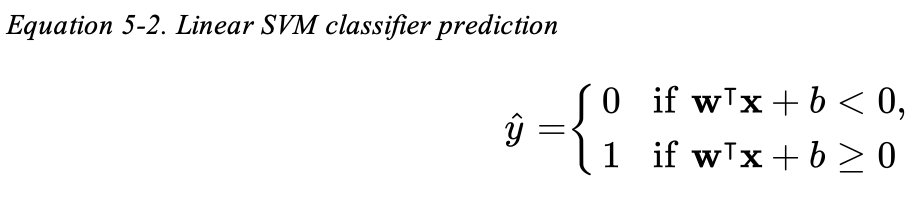

图5-12显示了与图5-4左侧模型相对应的决策函数：它是一个二维平面，因为这个数据集有两个特征（花瓣宽度和花瓣长度）。决策边界是决策函数等于0的点集：它是两个平面的交集，这是一条直线（由厚实线表示）。

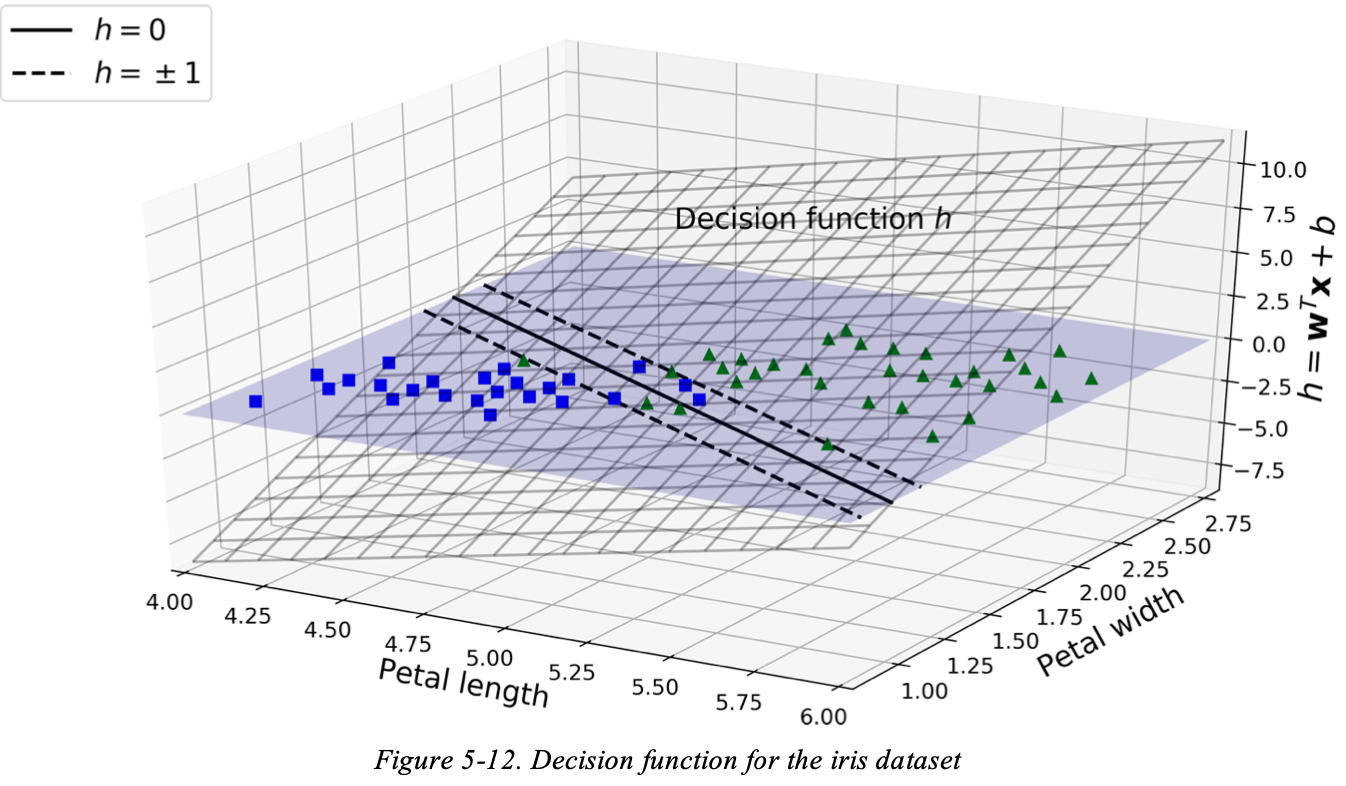

虚线表示决策函数等于 1 或 -1 的点：它们与决策边界平行，距离相等，并在决策边界周围形成边距。训练线性SVM分类器意味着找到 $w$ 和 $b$ 的值，使该边距尽可能宽，同时避免 margin violations（硬边距）或限制它们（soft margin）。


### Training Objective


考虑决策函数的斜率：它等于权重矢量的范数 $\| w \|$。 如果我们将这个斜率除以2，决策函数等于 $±1$ 的点将离决策边界的两倍。换句话说，将斜率除以2会将边距乘以2。这可能更容易在 2D 中可视化，如图5-13所示。重量矢量 $w$ 越小，边距越大。

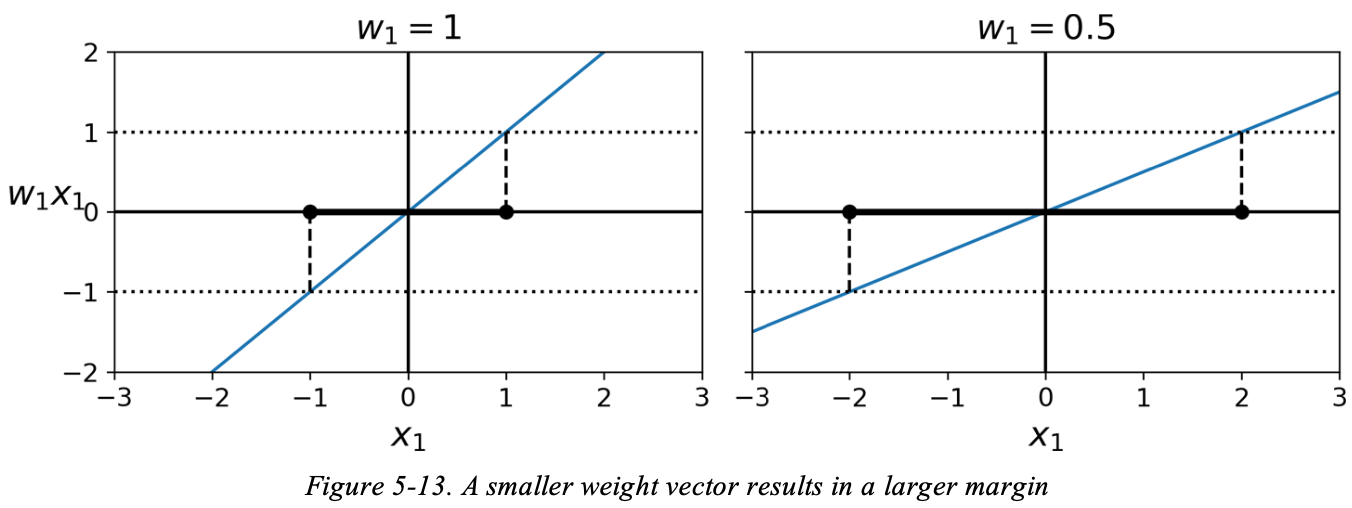

因此，我们希望最大限度地减少 $\| w \|$，以获得很大的 margin。如果我们也想避免任何 margin violations（hard margin），那么对于所有正训练实例，我们需要决策函数大于1，对于负训练实例，决策函数小于-1。如果我们为负实例定义 $t^{(i)} = –1（if y^{(i)} = 0)$，对正实例定义$t^{(i)} = 1（如果y^{(i)} = 1）$，那么对于所有实例，我们可以将此约束表示为 $t^{(i)}(w^Tx^{(i) + b}) \geq 1$。

因此，我们可以将  hard margin 线性支持向量机分类器目标表示为方程5-3中的约束优化问题。

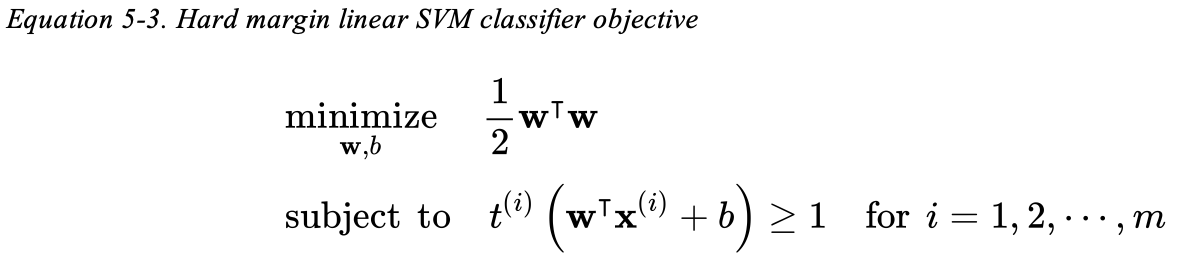

> NOTE: 我们可以最小化 $\frac{1}{2}w^Tw$, 其等于 $\frac{1}{2} \| w \|^2$, 而不是最小化 $\| w \|$。 事实上， $\frac{1}{2} \| w \|^2$ 有一个好的简单的微分(它是 $w$)， 尽管 $\| w \|$ 在 $ w = 0$ 是不可微的。 优化算法在可微函数上表现地更好。

为了得到 soft margin objective， 我们需要为每个实例引入一个 slack variable $\xi^{(i)} \geq 0$: $\xi^{(i)}$ 测量 $i^{th}$ 实例允许多少 violatet the margin。 我们现在有两个相互冲突的目标：使 slack 变量尽可能小，以减少 margin violations，使 $\frac{1}{2}w^Tw$ 尽可能小以减少 margin。 这是 $C$ 超参数的作用： 它允许我们定义这两个目标之间的权衡。这给了我们方程5-4中的约束优化问题。

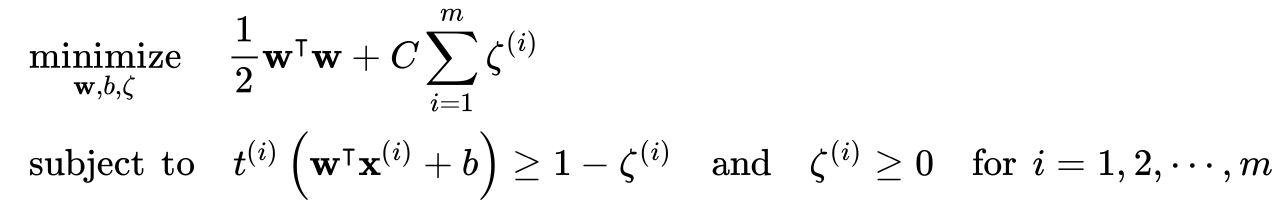

### Quadratic Programming

hard margin 和 soft margin 问题都是具有线性约束的凸二次优化问题。这样的问题叫做 `Quadratic Programming`(QP) 问题。 许多现成的求解器可以通过使用本书范围之外的各种技术来解决QP问题。

通用问题公式由方程5-5给出。

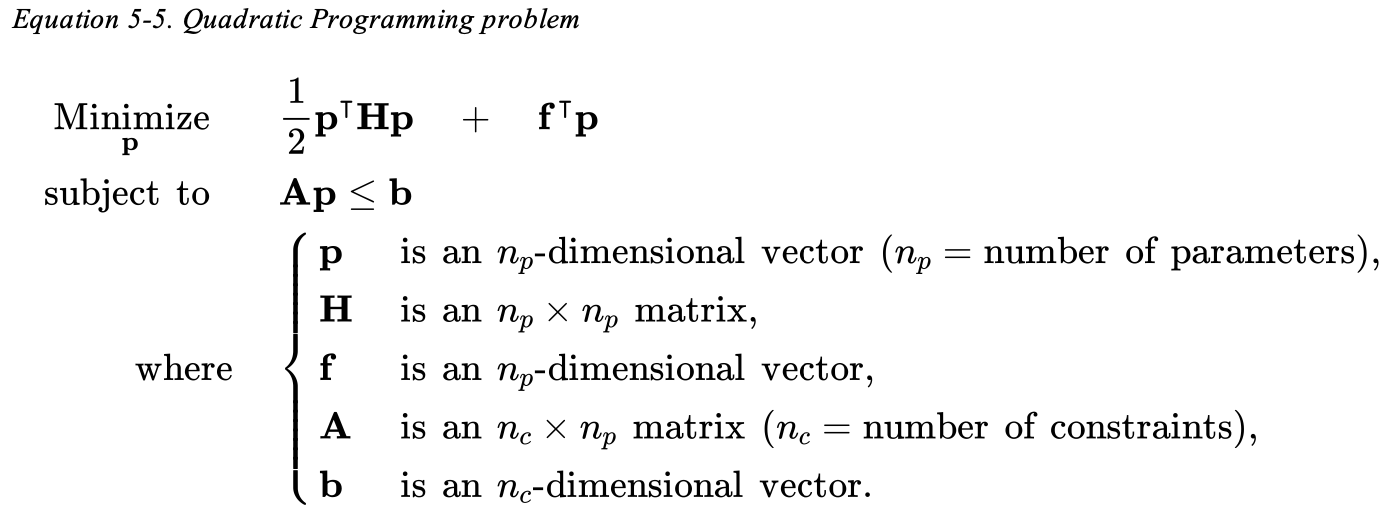

注意表达式 $Ap \leq b$ 定义在 $n_c$ 个约束下： $p^T a^{(i)} \leq b^{b^{i}}$ 对于 $i = 1, 2, ..., n_c$， 其中 $a^{(i)}$ 是 $A$ 第 $i^{th}$ 行的向量， $b^{i}$ 是 $b$ 的第 $i^{th}$ 个元素。

您可以轻松验证，如果您以以下方式设置 QP 参数，您将获得 hard margin 线性SVM分类器目标：

- $n_p = n + 1$， 其中 $n$ 是特征的数量
- $n_c = m$， 其中 $m$ 是训练样本的数量
- $H$ 是 $n_p \times n_p$ 的 identity 矩阵， 除了左上角有一个 0 (忽略 bias 项)
- $f = 0$, 一个 $n_p$ 维的全 0 向量
- $b = -1$, 一个 $n_c$ 维的全 -1 向量
- $a^{i} = -t^{(i)} \dot x^{(i)}$， 其中 $\dot x^{(i)}$ 等于 $x^{i}$ 带上一个偏置特征 $\dot x_0 = 1$

训练 hard margin 线性SVM分类器的一种方法是使用现成的QP求解器，并通过上述参数。得到的向量 $p$ 包含偏置项 $b = p_0$ 和 特征权重 $w_i = p_i$。 相似地， 你可以使用一个 QP solver 解决 soft margin 问题。

要使用 kernel trick，我们将研究一个不同的约束优化问题。

### The Dual Problem

给定一个称为原始问题的约束优化问题，可以表示一个不同但密切相关的问题，称为其对偶问题 `dual problem`。对偶问题的解通常给出原始问题的解的下限，但在某些情况下，它可以有与原始问题相同的解。 幸运的是，支持向量机问题恰好满足了这些条件，因此您可以选择解决原始问题或对偶问题；两者都有相同的解。方程5-6显示了线性支持向量机目标的对偶形式（如果您想知道如何从原始问题中推导出对偶问题，请参阅附录C）。

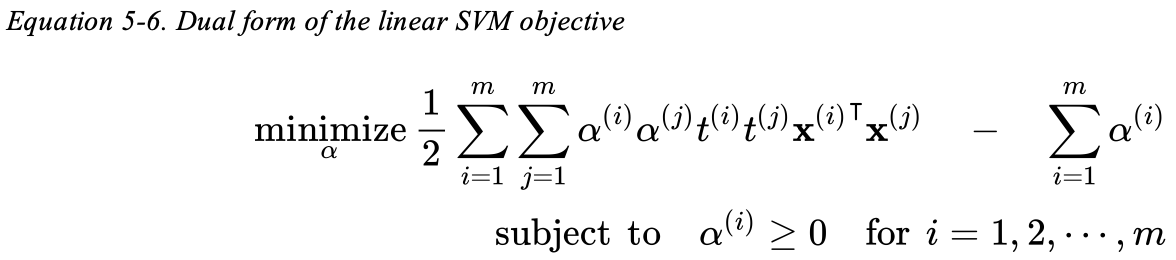

一旦您找到最小化此方程的向量$\hat \alpha$（使用QP求解器），请使用方程5-7进行计算 $\hat w$ 和 $\hat b$，并将原始问题最小化。

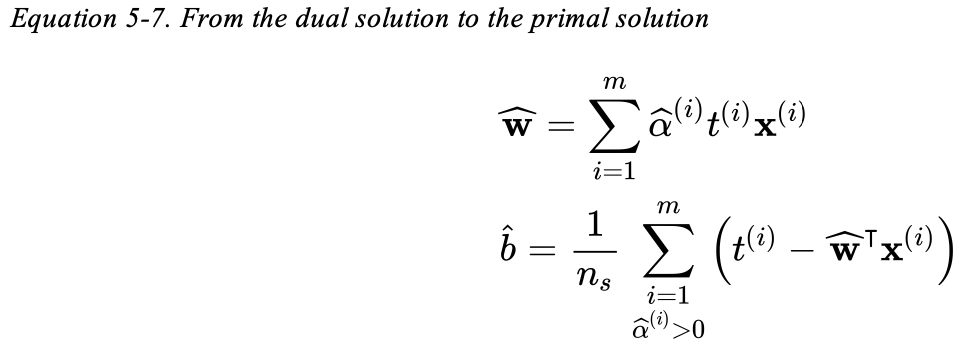


当训练实例数量小于特征数量时，对偶问题比原始问题解决得更快。更重要的是，对偶问题使 kernel trick 成为可能，而原始则不行。那么，这个 kernel trick 到底是什么？

### Kernelized SVMs

假设您想将二阶多项式变换应用于二维训练集（如卫星训练集），然后在转换后的训练集上训练线性SVM分类器。方程5-8显示了您想要应用的二阶多项式映射函数 $\phi$。

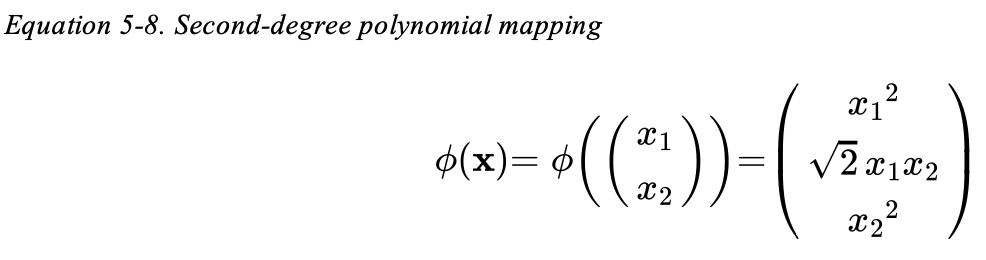

请注意，转换的向量是3D而不是2D。现在让我们看看，如果我们应用这个二阶多项式映射，然后计算转换向量的点积，那么几个二维向量 $a$ 和 $b$ 会发生什么（见方程5-9）。

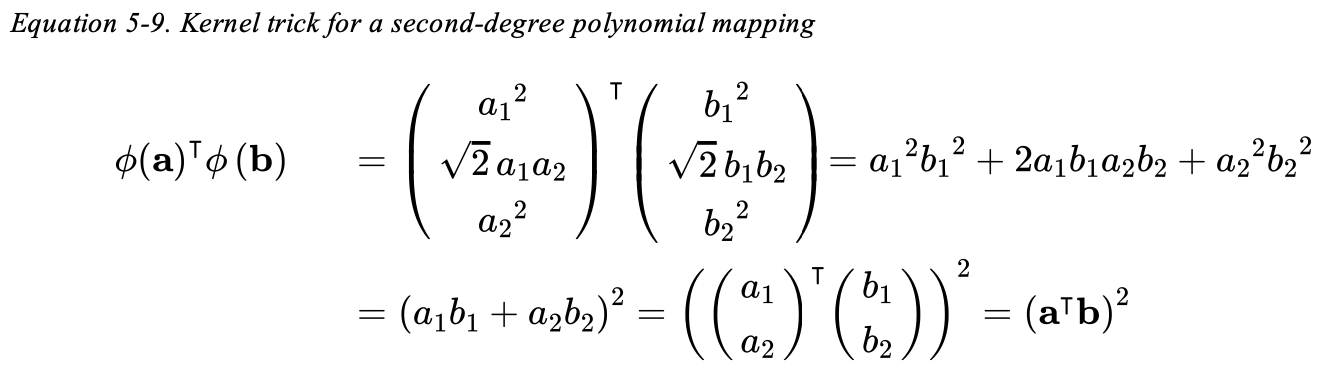


那怎么样？转换向量的点积等于原始向量的点积的平方：$\phi(a)^T \phi(b) = (a^Tb)^2$

以下是关键见解：如果您将转换 $\phi$ 应用于所有训练实例，那么对偶问题（见方程5-6）将包含点积 $\phi(x^{(i)})\phi(x^{(j)})$。但是如果 $\phi$ 是公式 5-8 中二阶多项式变换， 然后你可以通过 $(x^{(i)^T} x^{(j)})^2$。因此，您无需完全转换训练实例；只需在方程5-6中将点积替换为平方。结果将与您经历过转换训练集然后拟合线性支持向量机算法完全相同，但这个技巧使整个过程的计算效率更高。

函数 $K(a, b) = (a^T b)^2$ 是一个二阶多项式 kernel。在机器学习中，kernel 是一个能够仅基于原始向量 $a$ 和 $b$ 计算点积 $\phi(a)\phi(b)$ 的函数，而无需计算（甚至不知道）变换 $\phi$。方程5-10列出了一些最常用的 kernel。

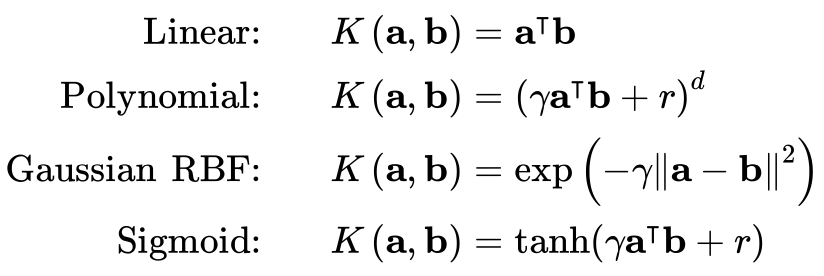


> MERCER'S 定理： 根据 `Mercer's theorem`， 如果一个函数 $K(a, b)$ 服从叫做 Mercer's conditions 的数学调教(例如， $K$ 必须连续并且对称， $K(a, b) = K(b, a)$ 等等)， 存在一个函数 $\phi$ 其映射 $a$ 和 $b$ 到另一个空间(可能有更高的维度), 例如 $K(a, b) = \phi(a)^T \phi(b)$。 你可以使用 $K$ 作为 kernel 因为你知道 $\phi$ 存在， 即便你不知道 $\phi$ 是什么。 在高斯 RBF kernel 的情况下， $\phi$ 映射每个训练样本为一个有限维空间， 因此你不必真正实现映射！
>
> 请注意，一些常用的 kernel（如 sigmoid kernel）不服从 Mercer 的所有条件，但它们在实践中通常效果很好。

方程5-7展示了如何在 线性支持向量机分类器 的情况下从对偶解到原始解。但是如果你使用了 kernel trick， 你最后包含 $\phi(x^{(i)})$ 在等式中。事实上， $\hat w$ 必须有和 $\phi(x^{(i)})$ 相同的维度数量， 其可能很大甚至无穷， 因此你不能计算它。 但是你如何在不知道 $\hat w$ 的情况下预测呢？ 好消息是你可以为一个新样本 $x^{(n)}$ 从公式 5-7 中为  $\hat w$  插入公式到决策函数， 然后你可以得到输入向量之间点积的等式。这使得 kernel trick 成为可能(等式 5-11)。

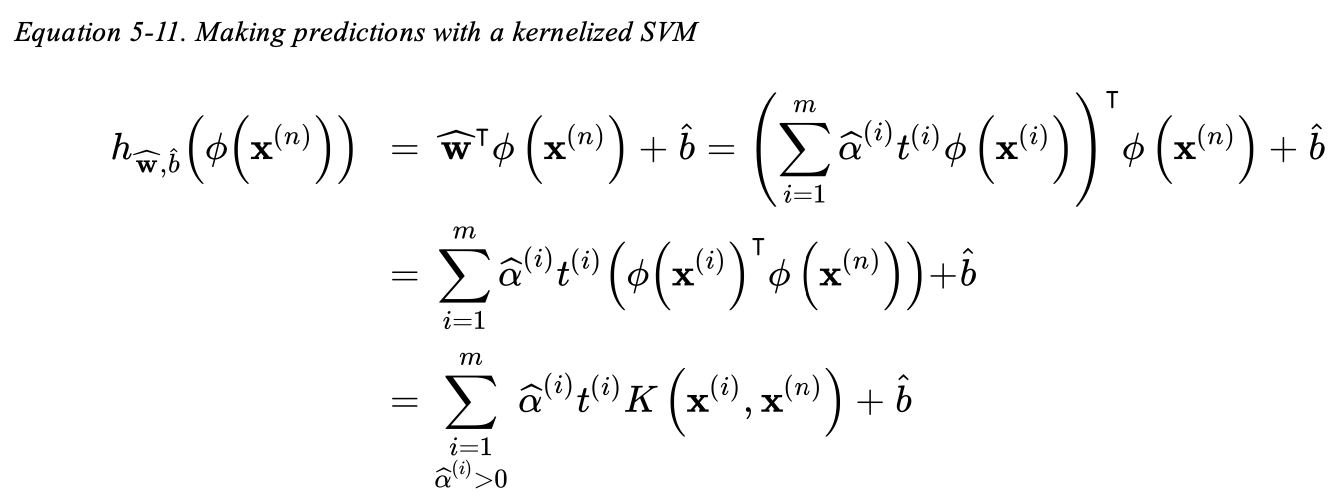

注意因为 $\alpha^{(i)} \neq 0$ 仅用于支持向量， 预测涉及仅使用支持向量计算新输入向量 $x^{(n)}$ 的点积, 不是所有训练样本。当然， 你需要使用相同的 trick 计算偏置项 $\hat b$(等式 5-12)。

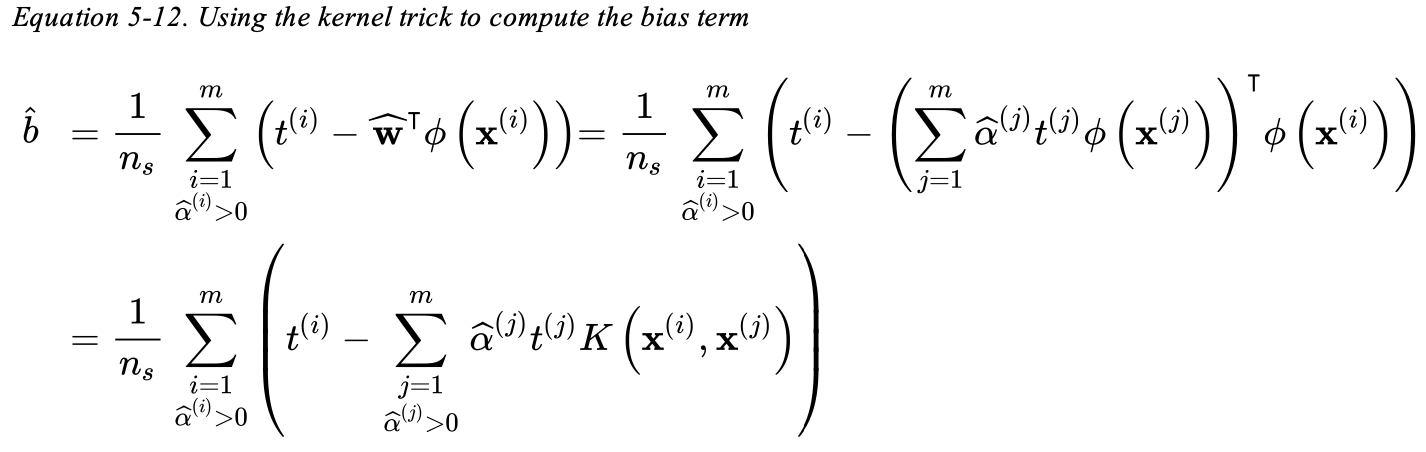

如果你开始头疼，这是完全正常的：这是 kernel trick 的不幸副作用。

### Online SVMs

在结束本章之前，让我们快速看看在线SVM分类器（请记住，在线学习意味着逐步学习，通常是随着新样本的到来）。

对于线性 SVM 分类器， 一种用于实现一个在线 SVM 分类器的方法是使用梯度下降 (例如， 使用 `SGDClassifier`) 来最小化等式 5-13 中的代价函数， 其来自于原始问题。 不幸的是， 梯度下降的收敛速度相比于基于 QP 的方法慢得多。

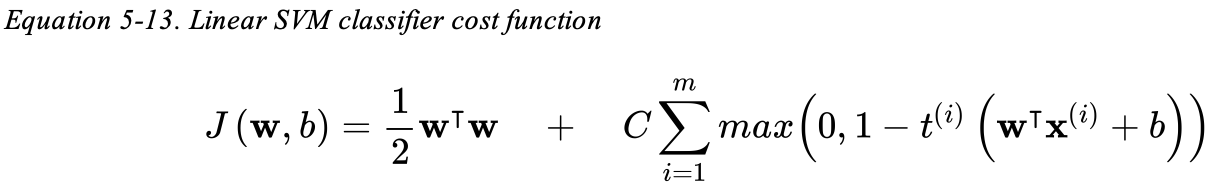

代价函数中的第一个 sum 将推动模型有一个小的权重向量 $w$ ，从而导致更大的 margin。第二 sum 计算所有 margin violations 的总和。如果实例位于 street 外和正确的一侧，则其 margin violation 等于0，或者它与 street 正确一侧的距离成正比。尽量减少该项可以确保该模型使  margin violations  行为尽可能少。

> HINGE LOSS: 函数 $\max(0, 1-t)$ 被叫做 `hinge loss` 函数(见如下的图)。 当 $t \geq 1$ 时， 它等于 0。 如果 $t < 1$ 它的导数(斜率)等于 -1， 如果 $t > 1$ 等于 0。 当 $t=1$ 时不可微， 但是想 Lasso Regression 一样， 你可以在 $t=1$ 使用任意 `subderivative` 使用梯度下降(值在 -1 到 0 之间)。
> 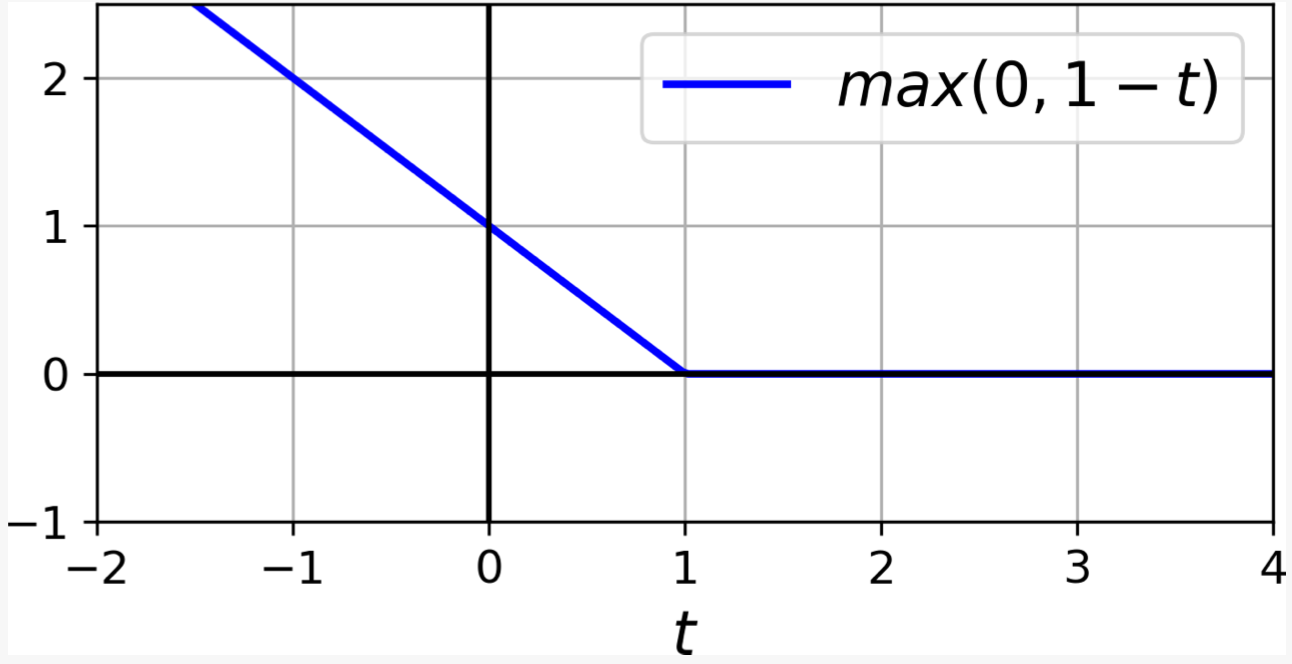

也有可能实现在线 kernelized SVMs, 就想 paper “Incremental and Decremental Support Vector Machine Learning” 和 “Fast Kernel Classifiers with Online and Active Learning” 中所描述的那样。 这些 kernelized SVM 是在 Matlab 和 C++ 中实现的。对于大规模的非线性问题，您可能需要考虑使用神经网络。
